# Nanoparticle Feature Setup <a name="head"></a>

This tutorial details how to generate features from a data set of nanoparticle atoms objects. The data imported here is for 147-atom AuPt alloyed nanoprticles with varying composition and chemical ordering.

## Table of Contents
[(Back to top)](#head)

-   [Requirements](#requirements)
-   [Initialization](#initialization)
-   [Generating Feature Vectors](#generating-feature-vectors)
-   [Storing Data](#storing-data)
-   [Retrieving Date](#retrieving-data)
-   [Conclusions](#conclusions)

## Requirements <a name="requirements"></a>
[(Back to top)](#head)

-   [CatLearn](https://github.com/SUNCAT-Center/CatLearn)
-   [ASE](https://wiki.fysik.dtu.dk/ase/)
-   [numpy](http://www.numpy.org/)

## Initialization <a name="initialization"></a>
[(Back to top)](#head)

To start with we import some functions from ASE and AtoML.

In [1]:
from IPython.display import Image

import os
import numpy as np
import random

from ase.ga.data import DataConnection
from ase.io import write
from ase import __version__
print(__version__)

from catlearn.api.ase_data_setup import get_unique, get_train
from catlearn.fingerprint.setup import FeatureGenerator, default_fingerprinters
from catlearn.utilities import DescriptorDatabase


3.16.0


## Generating Feature Vectors <a name="generating-feature-vectors"></a>
[(Back to top)](#head)

Some data is imported from an existing `ase.db`.

In [2]:
# Connect ase atoms database.
gadb = DataConnection('../../data/gadb.db')

# Get all relaxed candidates from the db file.
all_cand = gadb.get_all_relaxed_candidates(use_extinct=False)

The nanoparticles can be displayed with the following.

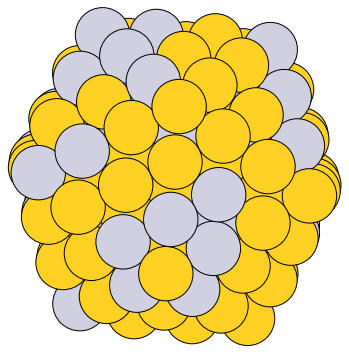

In [3]:
write('particle.png', all_cand[-100])
Image('particle.png')

There are a couple of functions that will make some selection of data for testing and training. In reality, it is far more robust to do this with some form of cross-validation, but this will suffice for this tutorial. The `get_unique` function will randomly select a defined data size. The `get_train` can then generate a training dataset with replacement. As the naming suggests, it is ensured none of the data in the unique dataset will make it into the training set.

In [4]:
testset = get_unique(atoms=all_cand, size=100, key='raw_score')

trainset = get_train(atoms=all_cand, size=500, taken=testset['taken'],
                     key='raw_score')

Once the atoms objects have been prepared, it is possible to generate the feature sets. This can be performed in parallel by setting `nprocs` greater than 1. If `None` is set then all available cores will be utilized. Two functions can be called to generate the feature sets `return_vec` and the feature names `return_names`.

In [5]:
generator = FeatureGenerator(atom_types=[78, 79], nprocs=4,
                             element_parameters='atomic_radius',
                             max_neighbors='full')
feature_names = default_fingerprinters(generator, 'fragment')
data = generator.return_vec(trainset['atoms'], feature_names)
vec_names = generator.return_names(feature_names)
print(np.shape(data))
print(vec_names)

(500, 155)
['eig_0' 'eig_1' 'eig_2' 'eig_3' 'eig_4' 'eig_5' 'eig_6' 'eig_7' 'eig_8'
 'eig_9' 'eig_10' 'eig_11' 'eig_12' 'eig_13' 'eig_14' 'eig_15' 'eig_16'
 'eig_17' 'eig_18' 'eig_19' 'eig_20' 'eig_21' 'eig_22' 'eig_23' 'eig_24'
 'eig_25' 'eig_26' 'eig_27' 'eig_28' 'eig_29' 'eig_30' 'eig_31' 'eig_32'
 'eig_33' 'eig_34' 'eig_35' 'eig_36' 'eig_37' 'eig_38' 'eig_39' 'eig_40'
 'eig_41' 'eig_42' 'eig_43' 'eig_44' 'eig_45' 'eig_46' 'eig_47' 'eig_48'
 'eig_49' 'eig_50' 'eig_51' 'eig_52' 'eig_53' 'eig_54' 'eig_55' 'eig_56'
 'eig_57' 'eig_58' 'eig_59' 'eig_60' 'eig_61' 'eig_62' 'eig_63' 'eig_64'
 'eig_65' 'eig_66' 'eig_67' 'eig_68' 'eig_69' 'eig_70' 'eig_71' 'eig_72'
 'eig_73' 'eig_74' 'eig_75' 'eig_76' 'eig_77' 'eig_78' 'eig_79' 'eig_80'
 'eig_81' 'eig_82' 'eig_83' 'eig_84' 'eig_85' 'eig_86' 'eig_87' 'eig_88'
 'eig_89' 'eig_90' 'eig_91' 'eig_92' 'eig_93' 'eig_94' 'eig_95' 'eig_96'
 'eig_97' 'eig_98' 'eig_99' 'eig_100' 'eig_101' 'eig_102' 'eig_103'
 'eig_104' 'eig_105' 'eig_106' 'eig_107' 'eig_

In [6]:
# Sanitize database inputs.
for j, name in enumerate(vec_names):
    vec_names[j] = ('f' + name).replace('-', '_')
print(len(vec_names))

155


## Storing Data <a name="storing-data"></a>
[(Back to top)](#head)

Once the features have been generated, it is possible to store them in a database. This initial implementation of the db isn't so optimal but is a simple way of temporarily storing all the feature vectors. The following lines of code will initialize the db.

In [7]:
# Define variables for database to store system descriptors.
descriptors = list(vec_names)
targets = ['Energy']
column_names = descriptors + targets

print(column_names[0], column_names[-1])

# Set up the database to save system descriptors.
dd = DescriptorDatabase(db_name='vec_store.sqlite')
dd.create_db(names=column_names)

feig_0 Energy


The code below will then reformat the data slightly, before storing it in the db. In this case the targets are stored in the `atoms.info['key_value_pairs']['raw_score']`. To keep track of where the feature vectors come from, the atoms UUID is utilized. This is stored in `atoms.info['unique_id']`.

In [8]:
# Put data in correct format to be inserted into database.
new_data = []
for i, a in zip(data, all_cand):
    d = []
    d.append(a.info['unique_id'])
    for j in i:
        d.append(j)
    d.append(a.info['key_value_pairs']['raw_score'])
    new_data.append(d)

# Fill the database with the data.
print(np.shape(new_data), len(column_names))
dd.fill_db(descriptor_names=column_names, data=new_data)

(500, 157) 156


It is possible to update the db as required. In the following, we just append some random variables from to the db.

In [9]:
dd.create_column(new_column=['random'])

# Add new name to list of descriptors.
descriptors += ['random']

for i in dd.query_db(names=['uuid']):
    dd.update_descriptor(
        descriptor='random', new_data=random.random(), unique_id=i[0])

## Retrieving Date <a name="retrieving-data"></a>
[(Back to top)](#head)

To check what data is now stored in the db, the following can be used.

In [10]:
stored = dd.get_column_names()
print('\nretrieved column names:\n{}'.format(stored))


retrieved column names:
['uuid', 'feig_0', 'feig_1', 'feig_2', 'feig_3', 'feig_4', 'feig_5', 'feig_6', 'feig_7', 'feig_8', 'feig_9', 'feig_10', 'feig_11', 'feig_12', 'feig_13', 'feig_14', 'feig_15', 'feig_16', 'feig_17', 'feig_18', 'feig_19', 'feig_20', 'feig_21', 'feig_22', 'feig_23', 'feig_24', 'feig_25', 'feig_26', 'feig_27', 'feig_28', 'feig_29', 'feig_30', 'feig_31', 'feig_32', 'feig_33', 'feig_34', 'feig_35', 'feig_36', 'feig_37', 'feig_38', 'feig_39', 'feig_40', 'feig_41', 'feig_42', 'feig_43', 'feig_44', 'feig_45', 'feig_46', 'feig_47', 'feig_48', 'feig_49', 'feig_50', 'feig_51', 'feig_52', 'feig_53', 'feig_54', 'feig_55', 'feig_56', 'feig_57', 'feig_58', 'feig_59', 'feig_60', 'feig_61', 'feig_62', 'feig_63', 'feig_64', 'feig_65', 'feig_66', 'feig_67', 'feig_68', 'feig_69', 'feig_70', 'feig_71', 'feig_72', 'feig_73', 'feig_74', 'feig_75', 'feig_76', 'feig_77', 'feig_78', 'feig_79', 'feig_80', 'feig_81', 'feig_82', 'feig_83', 'feig_84', 'feig_85', 'feig_86', 'feig_87', 'feig_88

To retrieve the features and targets, the following can be used.

In [11]:
# Test out the database functions.
train_fingerprint = dd.query_db(names=descriptors)
train_target = dd.query_db(names=targets)

print('\nfeature data for candidates: \n{}'.format(train_fingerprint[:10, :]))
print('\ntarget data for candidates: \n{}'.format(train_target[:10, :]))


feature data for candidates: 
[[  1.47494676e+05   4.53185605e+04   4.53130503e+04 ...,   1.42400000e+00
    9.03200000e+00   9.84270197e-01]
 [  1.47921350e+05   4.51058506e+04   4.50798149e+04 ...,   3.91666667e+00
    4.66666667e+00   3.91360052e-01]
 [  1.47595875e+05   4.50947660e+04   4.50763231e+04 ...,   8.00000000e+00
    2.73333333e+00   4.53203026e-01]
 ..., 
 [  1.47917521e+05   4.51816421e+04   4.51364334e+04 ...,   2.92592593e+00
    5.81481481e+00   2.39621007e-01]
 [  1.47422440e+05   4.52977242e+04   4.51917900e+04 ...,   3.06250000e+00
    7.08333333e+00   1.82152127e-01]
 [  1.45542817e+05   4.70783348e+04   4.46315491e+04 ...,   4.27536232e-01
    8.59420290e+00   2.74849323e-01]]

target data for candidates: 
[[ 5.11159468]
 [ 5.00676736]
 [ 4.92435745]
 [ 4.86020735]
 [ 4.81335412]
 [ 4.78863431]
 [ 4.7694978 ]
 [ 4.76147986]
 [ 4.72990291]
 [ 4.71992889]]


Finally, the folder can be tidied up.

In [12]:
os.remove('vec_store.sqlite')
os.remove('particle.png')

## Conclusions <a name="conclusions"></a>
[(Back to top)](#head)

This tutorial has demonstrated how to generate feature vectors for nanoparticle atoms objects and store that data in a temporary db.